In [1]:
!unzip "/content/drive/MyDrive/MSCOCO/Flicker8k_Dataset.zip" -d "/content"
!unzip "/content/drive/MyDrive/MSCOCO/Flickr8k_text.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Flicker8k_Dataset/2851198725_37b6027625.jpg  
  inflating: /content/Flicker8k_Dataset/2851304910_b5721199bc.jpg  
  inflating: /content/Flicker8k_Dataset/2851931813_eaf8ed7be3.jpg  
  inflating: /content/Flicker8k_Dataset/2852982055_8112d0964f.jpg  
  inflating: /content/Flicker8k_Dataset/285306009_f6ddabe687.jpg  
  inflating: /content/Flicker8k_Dataset/2853205396_4fbe8d7a73.jpg  
  inflating: /content/Flicker8k_Dataset/2853407781_c9fea8eef4.jpg  
  inflating: /content/Flicker8k_Dataset/2853743795_e90ebc669d.jpg  
  inflating: /content/Flicker8k_Dataset/2853811730_fbb8ab0878.jpg  
  inflating: /content/Flicker8k_Dataset/2854207034_1f00555703.jpg  
  inflating: /content/Flicker8k_Dataset/2854234756_8c0e472f51.jpg  
  inflating: /content/Flicker8k_Dataset/2854291706_d4c31dbf56.jpg  
  inflating: /content/Flicker8k_Dataset/2854959952_3991a385ab.jpg  
  inflating: /content/Flicker8k_Dataset/2855417531_521bf47b50.jpg 

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, GlobalAveragePooling1D, Add
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import keras.ops

# ==================== Configuration ====================
class Config:
    # Model parameters
    MAX_WORDS = 10000  # Vocabulary size
    MAX_LEN = 50  # Maximum sequence length
    EMBEDDING_DIM = 128

    # Transformer parameters
    NUM_HEADS = 8  # Number of attention heads
    FF_DIM = 512
    NUM_TRANSFORMER_BLOCKS = 2
    DROPOUT_RATE = 0.1

    # Emotions to detect
    EMOTIONS = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']
    NUM_CLASSES = len(EMOTIONS)

    # Training parameters
    BATCH_SIZE = 32
    EPOCHS = 20
    VALIDATION_SPLIT = 0.1

# ==================== Data Preparation ====================
class EmotionDataProcessor:
    """Process text data for emotion detection"""

    def __init__(self, max_words=Config.MAX_WORDS, max_len=Config.MAX_LEN):
        self.max_words = max_words
        self.max_len = max_len
        self.tokenizer = None
        self.emotion_to_idx = None
        self.idx_to_emotion = None

    def load_labeled_dataset(self, filepath, delimiter=';'):
        """
        Load your labeled dataset
        Format: sentence;emotion (16000 rows)
        Example: 'i feel happy;joy'
        """
        print(f"Loading dataset from {filepath}")

        # Read data
        df = pd.read_csv(filepath, delimiter=delimiter, names=['text', 'emotion'])

        # Clean data
        df['text'] = df['text'].str.strip()
        df['emotion'] = df['emotion'].str.strip().str.lower()

        # Filter to keep only the 6 emotions we want
        df = df[df['emotion'].isin(Config.EMOTIONS)]

        print(f"\nDataset loaded successfully!")
        print(f"Total samples: {len(df)}")
        print(f"\nEmotion distribution:")
        print(df['emotion'].value_counts())


        return df

    def prepare_flickr8k_captions(self, captions_file):
        """
        Load Flickr8k captions for emotion prediction

        Flickr8k format options:
        1. Flickr8k.token.txt: image_name#caption_number\tcaption
        2. CSV format: image_id,caption
        """
        print(f"\nLoading Flickr8k captions from {captions_file}")


        try:
            # Try tab-separated format first
            with open(captions_file, 'r', encoding='utf-8') as f:
                lines = f.readlines()

            captions_data = []
            for line in lines:
                if '\t' in line:
                    img_info, caption = line.strip().split('\t', 1)
                    img_name = img_info.split('#')[0]
                    captions_data.append({'image': img_name, 'caption': caption})

            df = pd.DataFrame(captions_data)

        except:

            df = pd.read_csv(captions_file)
            if 'caption' not in df.columns:
                # Try to identify caption column
                caption_col = [col for col in df.columns if 'caption' in col.lower()]
                if caption_col:
                    df.rename(columns={caption_col[0]: 'caption'}, inplace=True)

        print(f"Loaded {len(df)} Flickr8k captions")
        print(df.head())

        return df

    def tokenize_and_pad(self, texts):
        """Tokenize and pad text sequences"""
        if self.tokenizer is None:
            self.tokenizer = Tokenizer(
                num_words=self.max_words,
                filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',
                lower=True
            )
            self.tokenizer.fit_on_texts(texts)

        sequences = self.tokenizer.texts_to_sequences(texts)
        padded = pad_sequences(sequences, maxlen=self.max_len, padding='post')

        return padded

    def prepare_data(self, df, is_training=True):
        """Prepare data for training or prediction"""
        # Tokenize texts
        X = self.tokenize_and_pad(df['text' if 'text' in df.columns else 'caption'].values)

        if is_training:
            # Encode emotion labels for training
            if self.emotion_to_idx is None:
                self.emotion_to_idx = {emotion: idx for idx, emotion in enumerate(Config.EMOTIONS)}
                self.idx_to_emotion = {idx: emotion for emotion, idx in self.emotion_to_idx.items()}

            y = np.array([self.emotion_to_idx[emotion] for emotion in df['emotion']])
            y = keras.utils.to_categorical(y, num_classes=Config.NUM_CLASSES)

            return X, y
        else:
            # For prediction only
            return X

    def save_tokenizer(self, filepath='tokenizer.pkl'):
        """Save tokenizer for later use"""
        with open(filepath, 'wb') as f:
            pickle.dump({
                'tokenizer': self.tokenizer,
                'emotion_to_idx': self.emotion_to_idx,
                'idx_to_emotion': self.idx_to_emotion
            }, f)
        print(f"Tokenizer saved to {filepath}")

    def load_tokenizer(self, filepath='tokenizer.pkl'):
        """Load saved tokenizer"""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            self.tokenizer = data['tokenizer']
            self.emotion_to_idx = data['emotion_to_idx']
            self.idx_to_emotion = data['idx_to_emotion']
        print(f"Tokenizer loaded from {filepath}")

# ==================== Transformer Model Architecture ====================
class TransformerBlock(keras.layers.Layer):
    """Transformer block with multi-head attention"""

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        # Multi-head attention
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

class PositionalEmbedding(keras.layers.Layer):
    """Positional embedding for transformer"""

    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = keras.ops.shape(x)[-1] # Changed from tf.shape
        positions = keras.ops.arange(start=0, stop=maxlen, dtype='int32') # Changed from tf.range and added dtype
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

def build_transformer_model():
    """
    Build Transformer model for emotion classification

    Architecture:
    - Positional Embedding layer
    - Multiple Transformer blocks with multi-head attention
    - Global Average Pooling
    - Dense layers with dropout
    - Softmax output for 6 emotions
    """
    # Input layer
    inputs = Input(shape=(Config.MAX_LEN,))

    # Positional embedding
    embedding_layer = PositionalEmbedding(
        maxlen=Config.MAX_LEN,
        vocab_size=Config.MAX_WORDS,
        embed_dim=Config.EMBEDDING_DIM
    )
    x = embedding_layer(inputs)

    # Transformer blocks
    for _ in range(Config.NUM_TRANSFORMER_BLOCKS):
        x = TransformerBlock(
            embed_dim=Config.EMBEDDING_DIM,
            num_heads=Config.NUM_HEADS,
            ff_dim=Config.FF_DIM,
            rate=Config.DROPOUT_RATE
        )(x)

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Dense layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer (6 emotions)
    outputs = Dense(Config.NUM_CLASSES, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# ==================== Training and Evaluation ====================
class EmotionDetector:
    """Main emotion detection class with Transformer"""

    def __init__(self):
        self.model = None
        self.processor = EmotionDataProcessor()
        self.history = None

    def train(self, X_train, y_train, X_val, y_val):
        """Train the model"""
        print("\n" + "="*50)
        print("Building Transformer Model")
        print("="*50)

        self.model = build_transformer_model()
        self.model.summary()

        # Callbacks
        early_stop = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=0.00001
        )

        print("Training Model")

        self.history = self.model.fit(
            X_train, y_train,
            batch_size=Config.BATCH_SIZE,
            epochs=Config.EPOCHS,
            validation_data=(X_val, y_val),
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )

        return self.history

    def evaluate(self, X_test, y_test):
        """Evaluate model performance"""
        print("\n" + "="*50)
        print("Evaluating Model")
        print("="*50)

        # Predictions
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)

        # Classification report
        print("\nClassification Report:")
        print(classification_report(
            y_true_classes,
            y_pred_classes,
            target_names=Config.EMOTIONS
        ))

        # Confusion matrix
        cm = confusion_matrix(y_true_classes, y_pred_classes)

        return y_pred_classes, y_true_classes, cm

    def predict_emotion(self, text):
        """Predict emotion for a single text"""
        if self.model is None:
            raise ValueError("Model not trained yet!")

        # Preprocess text
        X = self.processor.tokenize_and_pad([text])

        # Predict
        pred = self.model.predict(X, verbose=0)
        emotion_idx = np.argmax(pred[0])
        confidence = pred[0][emotion_idx]
        emotion = self.processor.idx_to_emotion[emotion_idx]

        # Get all probabilities
        all_emotions = {self.processor.idx_to_emotion[i]: float(pred[0][i])
                       for i in range(Config.NUM_CLASSES)}

        return emotion, confidence, all_emotions

    def predict_flickr8k_emotions(self, flickr_df):
        """
        Predict emotions for all Flickr8k captions
        Returns DataFrame with captions and predicted emotions
        """
        if self.model is None:
            raise ValueError("Model not trained yet!")

        print("Predicting Emotions for Flickr8k Captions")

        captions = flickr_df['caption'].values
        X = self.processor.tokenize_and_pad(captions)

        # Batch prediction
        predictions = self.model.predict(X, batch_size=64, verbose=1)

        # Extract emotions and confidences
        emotion_indices = np.argmax(predictions, axis=1)
        confidences = np.max(predictions, axis=1)
        emotions = [self.processor.idx_to_emotion[idx] for idx in emotion_indices]

        # Add to dataframe
        result_df = flickr_df.copy()
        result_df['predicted_emotion'] = emotions
        result_df['confidence'] = confidences

        # Add individual emotion probabilities
        for i, emotion in enumerate(Config.EMOTIONS):
            result_df[f'prob_{emotion}'] = predictions[:, i]

        print(f"\nPrediction complete for {len(result_df)} captions!")
        print("\nEmotion distribution in Flickr8k:")
        print(result_df['predicted_emotion'].value_counts())

        return result_df

    def save_model(self, model_path='emotion_model_transformer.h5', tokenizer_path='tokenizer.pkl'):
        """Save trained model and tokenizer"""
        self.model.save(model_path)
        self.processor.save_tokenizer(tokenizer_path)
        print(f"\nModel saved to {model_path}")
        print(f"Tokenizer saved to {tokenizer_path}")

    def load_model(self, model_path='emotion_model_transformer.h5', tokenizer_path='tokenizer.pkl'):
        """Load trained model and tokenizer"""
        custom_objects = {
            'TransformerBlock': TransformerBlock,
            'PositionalEmbedding': PositionalEmbedding
        }
        self.model = keras.models.load_model(model_path, custom_objects=custom_objects)
        self.processor.load_tokenizer(tokenizer_path)
        print(f"\nModel loaded from {model_path}")
        print(f"Tokenizer loaded from {tokenizer_path}")

# ==================== Visualization ====================
def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title('Transformer Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title('Transformer Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history_transformer.png', dpi=300, bbox_inches='tight')
    print("\nTraining history plot saved as 'training_history_transformer.png'")

def plot_confusion_matrix(cm, normalize=False):
    """Plot confusion matrix"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt=fmt,
        cmap='Blues',
        xticklabels=Config.EMOTIONS,
        yticklabels=Config.EMOTIONS
    )
    plt.title(title + ' (Transformer Model)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('text_emotion_confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("\nConfusion matrix saved as 'text_emotion_confusion_matrix.png'")

# ==================== Main Execution ====================
def train_on_labeled_data(dataset_path='/content/emotion_dataset.txt'):

    print("TRAINING ......")

    # Initialize components
    processor = EmotionDataProcessor()
    detector = EmotionDetector()
    detector.processor = processor

    # Load labeled dataset
    df = processor.load_labeled_dataset(dataset_path, delimiter=';')

    # Prepare data
    print("\n" + "="*50)
    print("Preparing Training Data")
    print("="*50)

    X, y = processor.prepare_data(df, is_training=True)

    # Split data (80% train, 10% val, 10% test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1)
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1)
    )

    print(f"Training data: {len(X_train)}")
    print(f"Validation data: {len(X_val)}")
    print(f"Test data: {len(X_test)}")

    # Train model
    history = detector.train(X_train, y_train, X_val, y_val)

    # Evaluate model
    y_pred, y_true, cm = detector.evaluate(X_test, y_test)

    # Visualizations
    plot_training_history(history)
    plot_confusion_matrix(cm)

    # Save trained model
    detector.save_model('text_emotion_emotion_model.h5', 'text_emotion_tokenizer.pkl')

    return detector

def predict_flickr8k_emotions(flickr_captions_path='Flickr8k.token.txt',
                               model_path='text_emotion_emotion_model.h5',
                               tokenizer_path='text_emotion_tokenizer.pkl'):

    print("PREDICTING EMOTIONS IN FLICKR8K CAPTIONS")

    # Load trained model
    processor = EmotionDataProcessor()
    detector = EmotionDetector()
    detector.processor = processor
    detector.load_model(model_path, tokenizer_path)

    # Load Flickr8k captions
    flickr_df = processor.prepare_flickr8k_captions(flickr_captions_path)

    # Predict emotions
    results_df = detector.predict_flickr8k_emotions(flickr_df)

    # Save results
    output_file = 'text_emotion.csv'
    results_df.to_csv(output_file, index=False)
    print(f"\nResults saved to {output_file}")

def main():

    detector = train_on_labeled_data('text_emotion_dataset.txt')
    results = predict_flickr8k_emotions('Flickr8k.token.txt')

<>:122: SyntaxWarning: invalid escape sequence '\]'
<>:122: SyntaxWarning: invalid escape sequence '\]'
/tmp/ipython-input-59865583.py:122: SyntaxWarning: invalid escape sequence '\]'
  filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',


TRAINING ......
Loading dataset from text_emotion_dataset.txt

Dataset loaded successfully!
Total samples: 16000

Emotion distribution:
emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

Preparing Training Data
Training data: 12800
Validation data: 1600
Test data: 1600

Building Transformer Model


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding_1          │ (None, 50, 128)        │     1,286,400 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 50, 128)        │       659,712 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 50, 128)        │       659,712 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,630,982 (10.04 MB)

 Trainable params: 2,630,982 (10.04 MB)

 Non-trainable params: 0 (0.00 B)

Training Model
Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.3056 - loss: 1.6583 - val_accuracy: 0.3350 - val_loss: 1.5801 - learning_rate: 0.0010
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3311 - loss: 1.5930 - val_accuracy: 0.3350 - val_loss: 1.5814 - learning_rate: 0.0010
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3416 - loss: 1.5141 - val_accuracy: 0.3994 - val_loss: 1.1608 - learning_rate: 0.0010
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4463 - loss: 1.1426 - val_accuracy: 0.5531 - val_loss: 0.9829 - learning_rate: 0.0010
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5579 - loss: 0.9625 - val_accuracy: 0.5525 - val_loss: 0.9716 - learning_rate: 0.0010
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5845 - loss: 0.8793 - val_accuracy: 0.5406 - val_loss: 0.9804 - learning_rate: 0.0010
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0


Confusion matrix saved as 'text_emotion_confusion_matrix.png'
Tokenizer saved to text_emotion_tokenizer.pkl

Model saved to text_emotion_emotion_model.h5
Tokenizer saved to text_emotion_tokenizer.pkl
PREDICTING EMOTIONS IN FLICKR8K CAPTIONS


Tokenizer loaded from text_emotion_tokenizer.pkl

Model loaded from text_emotion_emotion_model.h5
Tokenizer loaded from text_emotion_tokenizer.pkl

Loading Flickr8k captions from Flickr8k.token.txt
Loaded 40460 Flickr8k captions
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
Predicting Emotions for Flickr8k Captions
633/633 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

Prediction complete for 40460 captions!

Emotion distribution in Flickr8k:
predicted_emotion
joy         22386
love         7660
sadness      6600
fear         2287

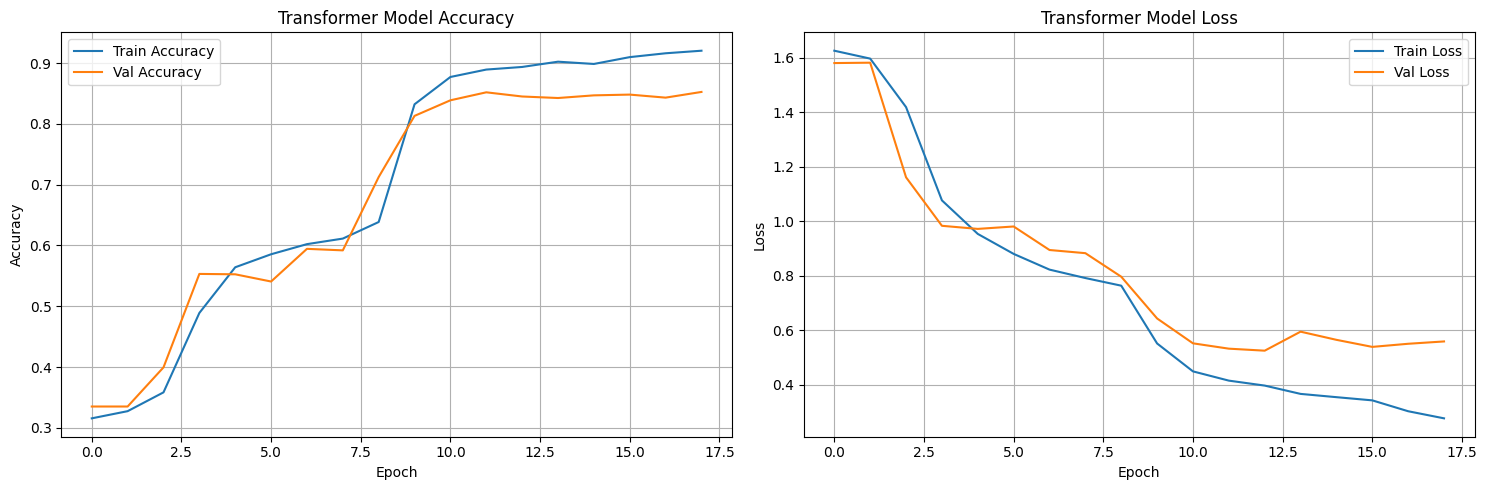

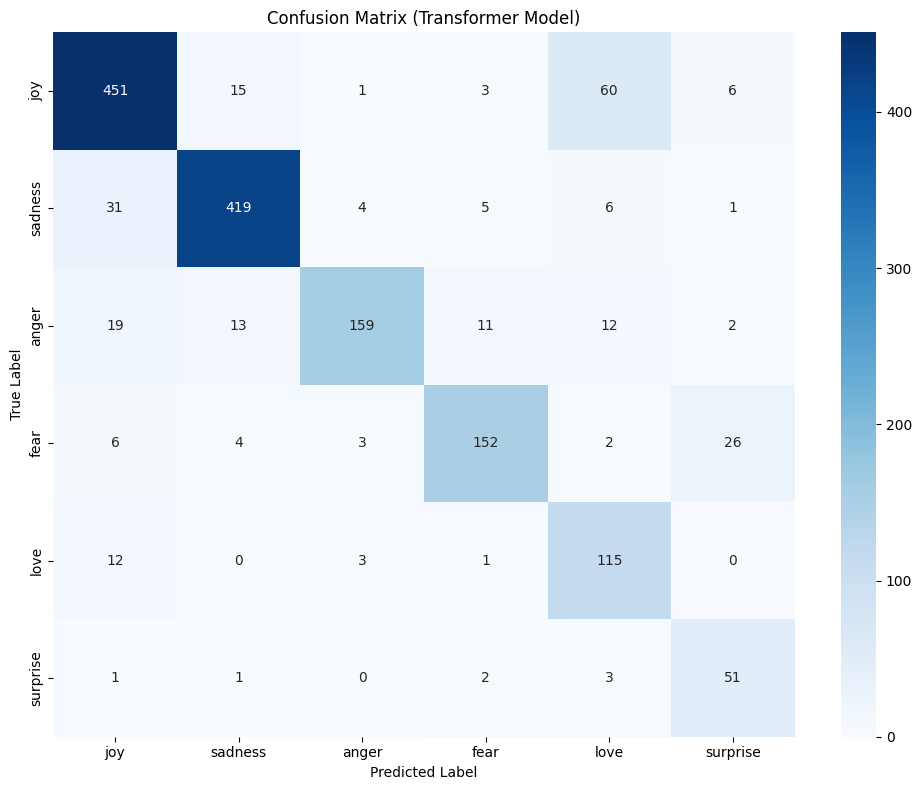

In [9]:
if __name__ == "__main__":
    main()